*****
# Necessary Library Import

In [1]:
import os
import sys
import json
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.preprocessing import StandardScaler
from lime.lime_tabular import LimeTabularExplainer
import shap
import lime
import joblib

np.random_seed = 42
warnings.filterwarnings("ignore")
sys.path.append(os.path.abspath("../"))

In [3]:
if not hasattr(np, 'str'):
    np.str = str
if not hasattr(np, 'asscalar'):
    np.asscalar = lambda x: x.item()
if not hasattr(np, 'bool'):
    np.bool = np.bool_
if not hasattr(np, 'int'):
    np.int = int
shap.initjs()

*****
# Dataset Import

In [4]:
# importing the dataset 
X_train = pd.read_csv("./../data/processed/v2/X_train.csv")
y_train = pd.read_csv("./../data/processed/v2/y_train.csv")
X_test = pd.read_csv("./../data/processed/v2/X_test.csv")
y_test = pd.read_csv("./../data/processed/v2/y_test.csv")

# importing the scaler 
scaler = joblib.load("./../data/processed/v2/scaler_version_v2.pkl")

# importing the decoder
with open("./../data/processed/encoding_mapping.json") as file:
    decoder = json.load(file)

# importing the model
from models.ensemble import *
classifier = joblib.load("./../models/v2/em_classifier_v2.pkl")

*****
# XAI Analyzer Wrapper

In [5]:
class XAIAnalyzer:
    def __init__(self, model):
        """ Initialize the XAIAnalyzer with the model."""
        self.model = model
        self.feature_names = []
        self.classes = []
        self.scaler = None
        self.X_test = None
        self.n_class = 0

    def fit(self, features, decoder, scaler, X_test):
        """ Fit the XAIAnalyzer with the provided features, decoder, scaler, and test data."""
        self.feature_names = features
        self.classes = list(decoder.keys())
        self.scaler = scaler
        self.X_test = X_test
        self.n_class = len(self.classes)

    def predict_proba(self,X):
        return self.model.predict_proba(X)[0]
    
    def analyze_lime(self, data, sample_idx: int = 0) -> None:
        """ Generate LIME explanations using scaled values for predictions and original values for display """
        value_df = pd.DataFrame(self.X_test, columns=self.feature_names)
        
        explainer = LimeTabularExplainer(
            training_data=self.X_test.values,
            feature_names=self.feature_names,
            class_names=self.classes,
            mode='classification',
            random_state=42
        )
        
        # explain new value
        sample_df = value_df.iloc[0]   # As DataFrame for feature names
        sample= data[0]   # as array for lime
        exp = explainer.explain_instance(
            data_row=sample,
            predict_fn=self.predict_proba,
            num_features=len(self.feature_names),
            top_labels=self.n_class
        )
        
        # get predicted class and probabilities
        probs = self.predict_proba(data)[0]
        probs = np.array(probs).flatten()

        pred_class = np.argmax(probs)
        print(f"Predicted class: {self.classes[pred_class]}")
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [1, 2]})
        
        #print(probs)    #debug 
        # Left: Prediction probabilities
        ax1.barh(range(self.n_class), probs, color='skyblue', edgecolor='black')
        ax1.set_yticks(range(self.n_class))
        ax1.set_yticklabels(self.classes)
        ax1.set_xlim(0, 1)
        ax1.set_xlabel('Prediction probabilities')
        for i, prob in enumerate(probs):
            ax1.text(prob + 0.02, i, f'{prob:.2f}', va='center')
            
        # Right: Feature contributions for the predicted class
        exp_list = exp.as_list(label=pred_class)
        features, weights = zip(*exp_list)
        colors = ['orange' if w > 0 else 'blue' for w in weights]
        ax2.barh(features, weights, color=colors)
        ax2.set_yticks(range(len(features)))
        ax2.set_yticklabels(features)
        ax2.set_ylim(-0.5, len(features) - 0.5)
        ax2.set_xlim(-max(abs(np.array(weights))) * 1.2, max(abs(np.array(weights))) * 1.2)
        for i, w in enumerate(weights):
            ax2.text(w + (0.02 if w > 0 else -0.02), i, f'{w:.2f}', va='center', ha='left' if w > 0 else 'right')
        ax2.set_title(f"Class {pred_class}", color='orange')

        plt.tight_layout()
        plt.title(f"Predicted Class: {self.classes[pred_class]}")
        plt.show()

*****
# Testing

In [6]:
# init model
features = list(X_test.columns)

xai_analyzer = XAIAnalyzer(model=classifier)

xai_analyzer.fit( 
    features=features,
    decoder=decoder,
    scaler=scaler,
    X_test=X_test
)

# testing data
org1 = np.array([82800000.0,0,0,232,380,0.0,2451350.5,11595,0,82800000,1947.6382,994,0.0,1,32,0,155.13435,380,45,0,1656.4286,1,921.1539,200,5792,63.333332,16600000.0,0])  # 4, 1
org2 = np.array([6004318.0,0,0,104,168,0.0,4335.4443,127,1,6004318,73.32349,574,0.0,1,32,0,75.13188,168,1695,0,42.333332,0,36.875,168,168,33.6,1506461.7805412144,0]) # 5, 1
scale1 = scaler.transform(org1.reshape(1, -1))  
scale2 = scaler.transform(org2.reshape(1, -1))
scale3 = np.array([-0.41961098,-0.2015657,-0.3167869,0.00070344,-0.05310197,-0.0705377,-0.40566528,-0.0061248164,-1.1977826,-0.40291056,-0.49845496,-0.1284633,-0.13401379,-0.012861779,0.0015755015,-0.16761528,-0.22970435,-0.19986987,-0.13780233,-0.2052994,-0.5537376,1.7072434,-0.5875015,0.00115011,-0.53635323,-0.19312523,-0.365365,-0.3387483]).reshape(1, -1)

print(f"Model Prediction Result: {classifier.predict(scale1)}")
print(f"Model Prediction Result: {classifier.predict(scale2)}")
print(f"Model Prediction Result: {classifier.predict(scale3)}")


Model Prediction Result: [[4 1]]
Model Prediction Result: [[5 1]]
Model Prediction Result: [[0 1]]


Predicted class: DoS


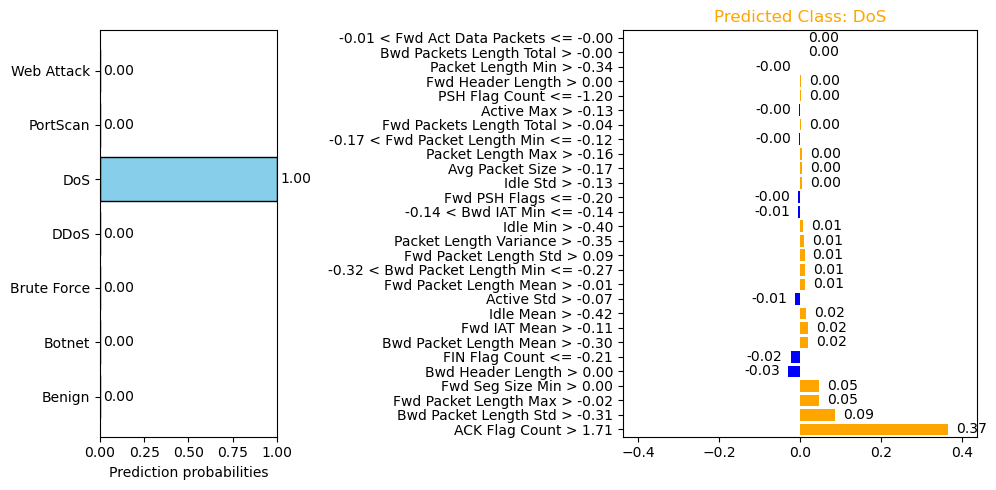

In [7]:
# xai explanation for scale 1
xai_analyzer.analyze_lime(scale1)

Predicted class: PortScan


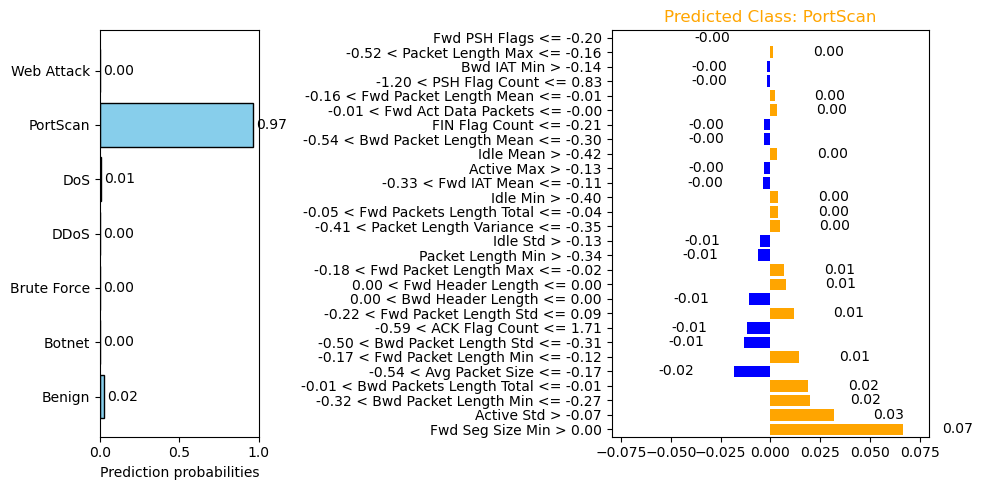

In [8]:
# xai explanation for scale 2
xai_analyzer.analyze_lime(scale2)

Predicted class: Benign


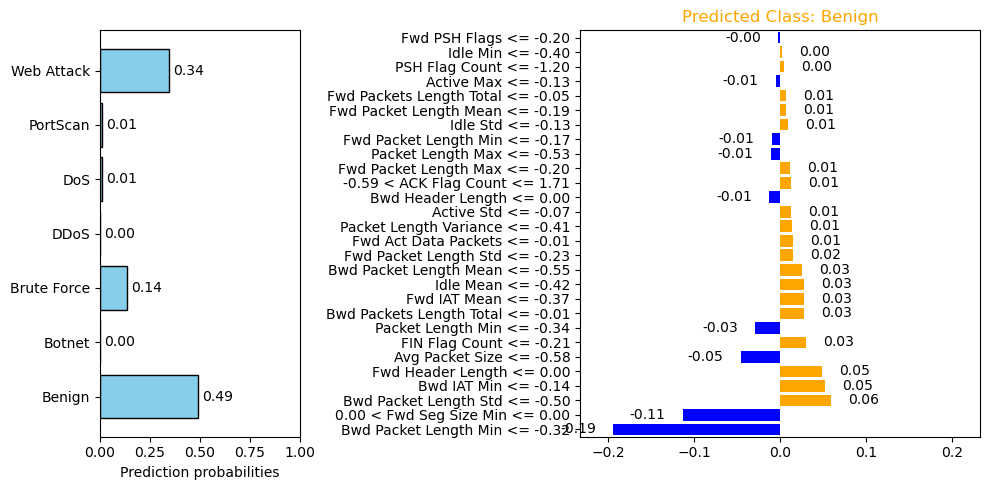

In [9]:
# xai explanation for scale 3
xai_analyzer.analyze_lime(scale3)

In [11]:
# saving the xai analyzer model
joblib.dump(xai_analyzer, './../models/xai_analyzer.pkl')

['./../models/xai_analyzer.pkl']

*****
# SHAP analyzer on test data

In [12]:
def multi_class_only_predict(X):
    return classifier.predict_proba(X)[0]

X_sampled = X_train.sample(500, random_state=42)

explainer = shap.Explainer(multi_class_only_predict, X_sampled)

shap_values = explainer(X_sampled)

Permutation explainer: 501it [01:41,  4.56it/s]                         


In [13]:
print(shap_values.shape)
shap_values_class = shap_values[:, 5]  # (500, n_features)
shap_values_transposed = shap_values.values.transpose(0, 2, 1)  
shap_values_class = shap_values_transposed[:, 4, :] # SHAP values for class 4 (DoS) for the first instance
shap_values_class.shape

(500, 28, 7)


(500, 28)

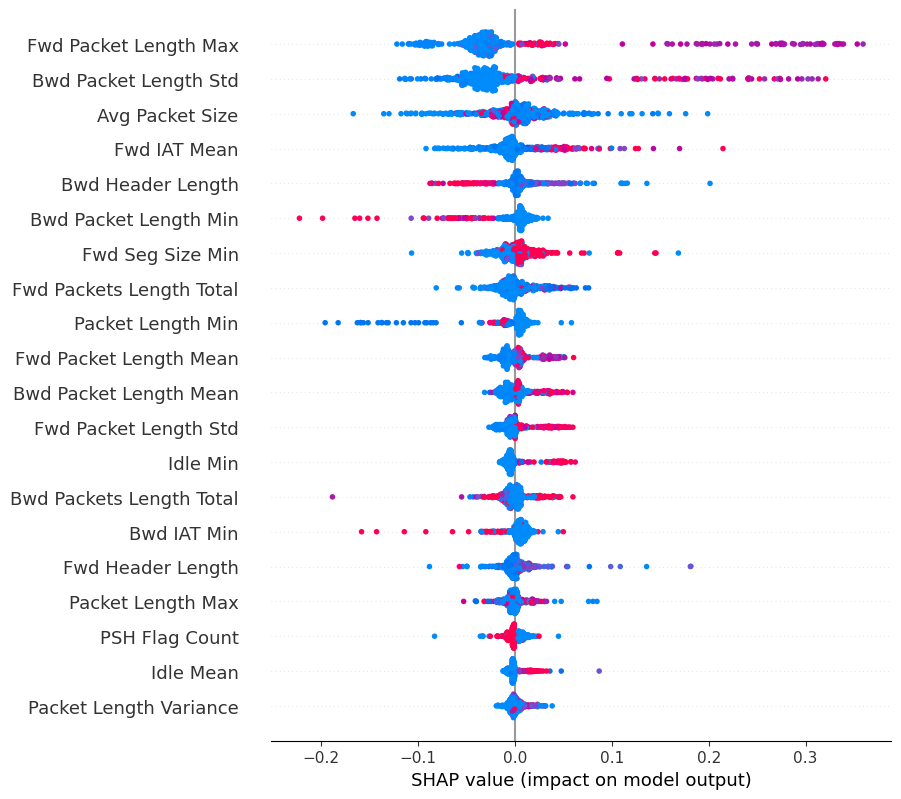

In [14]:
shap.summary_plot(
  shap_values_class,
  X_sampled, 
  feature_names=X_sampled.columns,
  color_bar=False
)

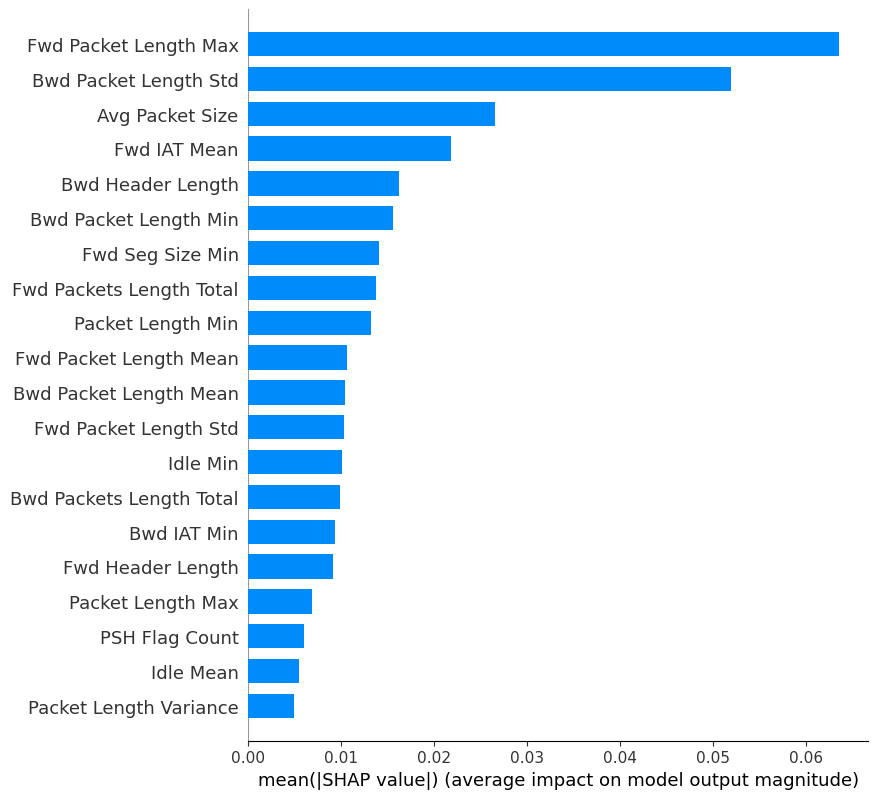

In [15]:
# Bar plot for the class 5 shap values
shap.summary_plot(
    shap_values_class,
    X_sampled,
    plot_type="bar",  # Specify bar plot
    feature_names=X_sampled.columns,
    color_bar=True
)

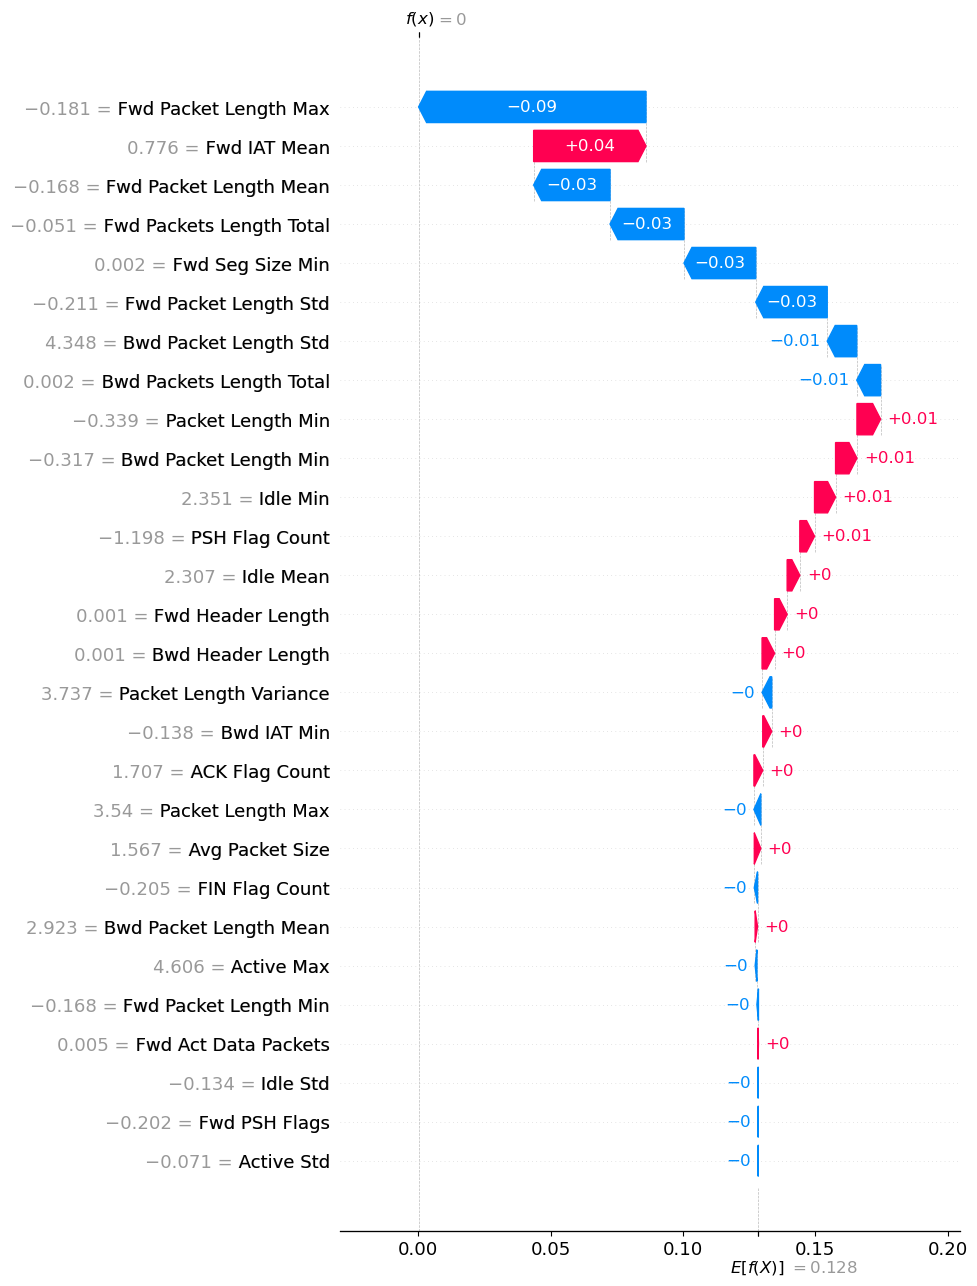

In [16]:
shap_value_class = shap_values[0][:, 4]  # SHAP values for class 4 (DoS) for the first instance

# Extract base value for class 5
base_value = shap_values.base_values[0][4]

# Create the waterfall plot
shap.waterfall_plot(shap_value_class, max_display=30) 

In [17]:
X_sampled = X_train.sample(100, random_state=42)

kexplainer = shap.KernelExplainer(multi_class_only_predict, X_sampled)
kshap_values = kexplainer.shap_values(X_sampled)

  0%|          | 0/100 [00:00<?, ?it/s]

In [21]:
# reshaping
print(len(kshap_values))  # 100
kshap_arr = np.array(kshap_values).T
print(kshap_arr.shape)  # (7, 28, 100)
kshap_arr = np.transpose(kshap_arr, (0, 2, 1))
print(kshap_arr.shape)  # (7, 100, 28)
kshap_values = list(kshap_arr)

100
(7, 28, 100)
(7, 100, 28)



SHAP Analysis for multi_class (using TreeExplainer):


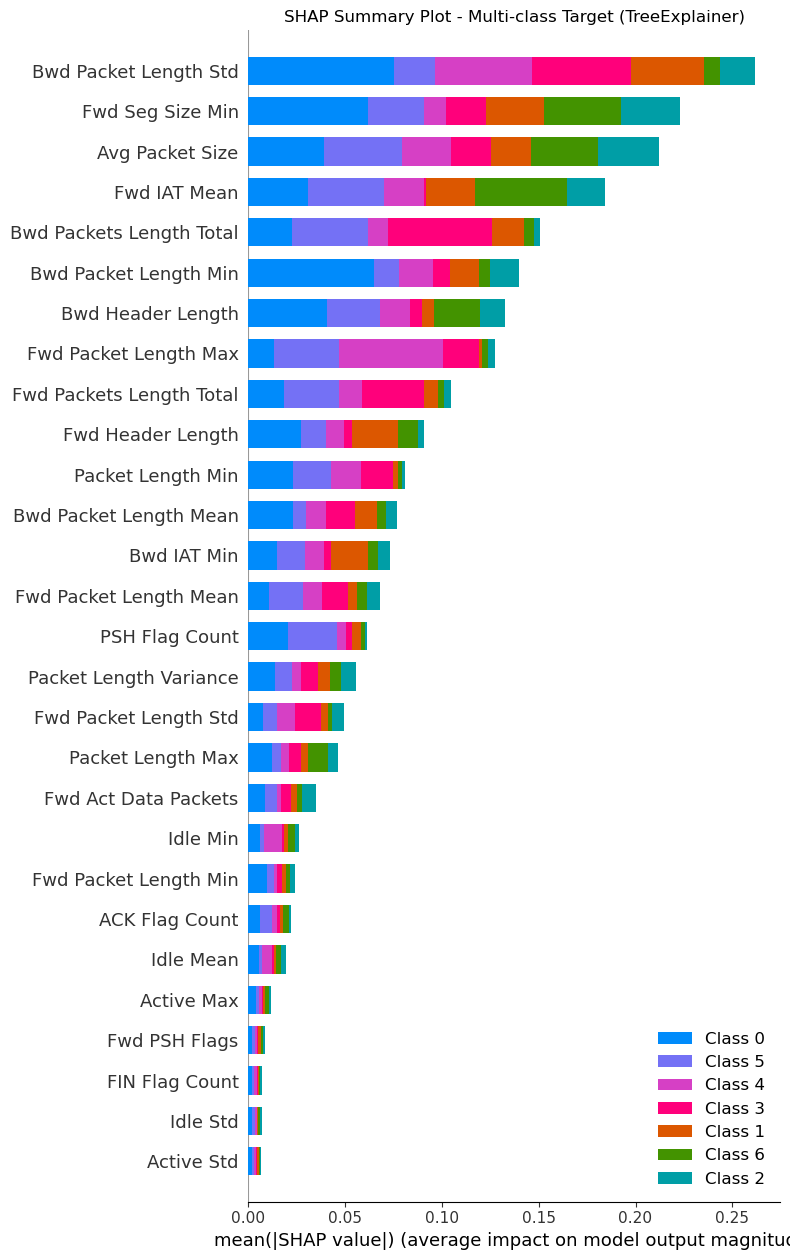

In [23]:
rng = np.random.default_rng(seed=42)
print("\nSHAP Analysis for multi_class (using TreeExplainer):")

# Summary plot for all classes combined
plt.figure(figsize=(10, 6))
shap.summary_plot(
    kshap_values,
    X_sampled,
    feature_names=X_test.columns,
    max_display=28,
    show=False,
    class_names=[f"Class {i}" for i in range(7)],
)
plt.title("SHAP Summary Plot - Multi-class Target (TreeExplainer)")
plt.tight_layout()
plt.show()
